<a href="https://colab.research.google.com/github/jugernaut/Induccion_MeIA/blob/angel/4_IntroduccionAA/CUDA/03_FractalesCUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="Teal" face="Comic Sans MS,arial">
  <h1 align="center"><i>Fractales CUDA</i></h1>
  </font>
  <font color="Black" face="Comic Sans MS,arial">
  <h5 align="center"><i>Profesor: M.en.C. Miguel Angel Pérez León</i></h5>
    <h5 align="center"><i>Ayudante: Jesús Iván Coss Calderón</i></h5>
  <h5 align="center"><i>Materia: Análisis Numérico</i></h5>
  </font>

# Introducción

Los fractales son unas de los temas más interesantes en el campo de las matemáticas.

Existen diferentes tipos de ellos pero el que vamos a analizar en este notebook es el fractal conocido como el "Fractal de Mandelbrot" que se ve de esta forma

<center>
<img src="https://github.com/jugernaut/MACTI-analisisnumerico/blob/main/09_ProgramacionParalelo/fig/mandel.png?raw=1" width="600">
</center>



## Fractales (*CUDA*)

Un fractal se define como un objeto geométrico en el que se repite el mismo patrón a diferentes escalas y con distinta orientación.

Estos objetos (fractales) son de interés particular en las ciencias debido a sus propiedades y características.

En esta sección vamos a ver las diferencias en términos de velocidad (tiempo de ejecución) de generar fractales con *Numba*, de manera secuencial y en paralelo usando la *GPU*.

## Sucesión de Mandelbrot

La sucesión de Mandelbrot se genera de la siguiente forma.

$$z_{n+1} = z_{n}^{2} + c$$

Donde: $z_{n}$ es un valor inicial (normalmente $z_{n}=0i$) y $c$ es un numero complejo

Esta suceción

$$f(z) = \{ z_{0}, z_{1}, ... , z_{n+1} \}$$

Puede que se convergente o divergente, si es convergente podemos decir que el número $c$ pertenece al conjunto de Mandelbrot, de otra forma no pertenece.

A contniación se muestran algunos ejemplos se muestra la función que genera dicha suceción dado un valor real y uno imaginario

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from numba import jit
from numba import njit
from numba import prange
from numba import cuda, float32

def grafmandelbrot(re, im, cuantos):
    c = complex(re, im)
    z = 0.0j
    valores = np.zeros(cuantos)
    for i in range(cuantos):
        z = z*z + c
        valores[i] = z.real*z.real + z.imag*z.imag
    return valores

Si graficamos esta sucesión para el complejo $c = 0 + 0i$ obtenemos la siguiente gráfica.

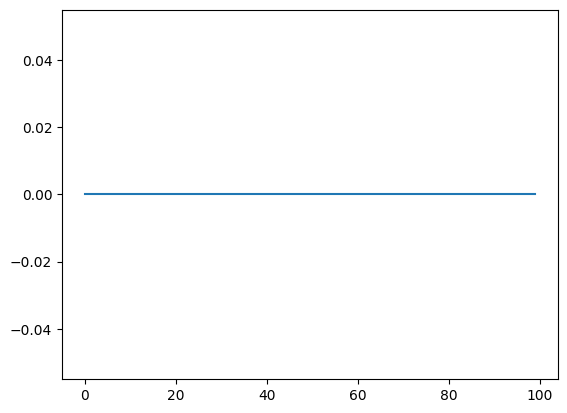

In [18]:
# c = 0+0i con 100 valores en la sucesion
mandel = grafmandelbrot(0, 0, 100)

plt.plot(mandel)

Si graficamos esta sucesión para el complejo $c = -2 - 2i$ obtenemos la siguiente gráfica.

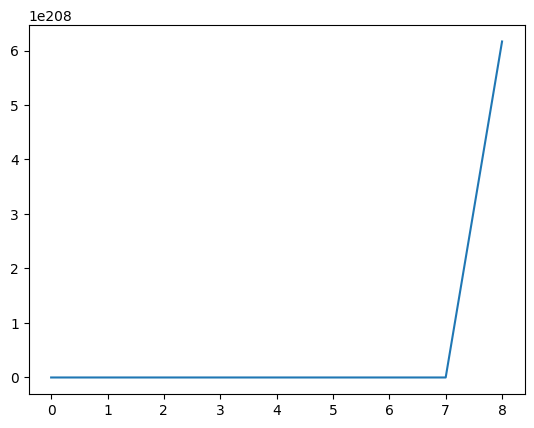

In [19]:
# c = 0+0i con 100 valores en la sucesion
mandel = grafmandelbrot(-2, -2, 100)

plt.plot(mandel)

Si graficamos esta sucesión para el complejo $c = 0 + 0.5i$ obtenemos la siguiente gráfica.

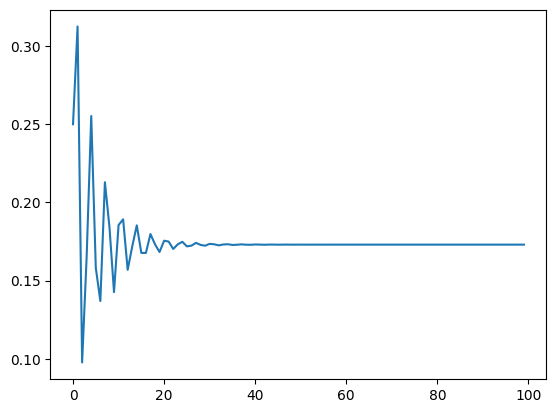

In [20]:
# c = 0+0i con 100 valores en la sucesion
mandel = grafmandelbrot(0, 0.5, 100)

plt.plot(mandel)

Si graficamos esta sucesión para el complejo $c = -0.25 - 0.25i$ obtenemos la siguiente gráfica.

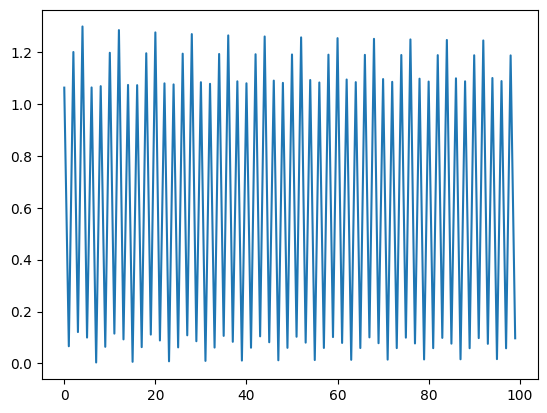

In [21]:
# c = 0+0i con 100 valores en la sucesion
mandel = grafmandelbrot(-1, -0.25, 100)

plt.plot(mandel)

## Graficando Mandelbrot

Dadas la sucesión de Mandelbrot podemos procedes a generar la gráfica en el plano complejo, de la siguiente forma.

*   Cosideremos los valores en el eje real entre $[-2, 1]$ y en el eje imaginario entre $[-1, 1]$ (rangos en el que se genera mejor el fractal).
*   Tomamos un número complejo (coordenada) en este rango y vemos si la sucesión de Mandelbrot converge o diverge.
*   En caso de que se de la convergencia, se pinta en amarillo, en otro caso se pinta en negro.

A continuación se muestra el código correspondiente a este algoritmo.

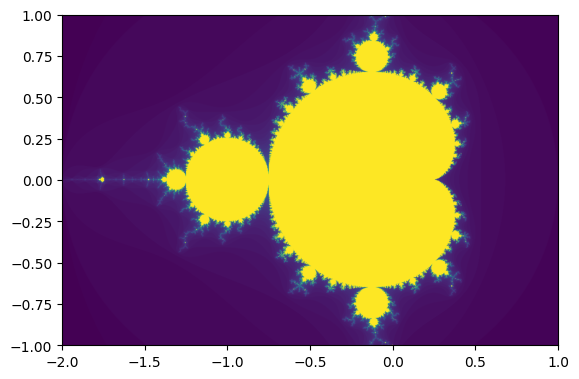

In [22]:
# funcion que nos dice si un complejo pertenece o no al fractal
def mandelbrot(re, im, max_iter):
    c = complex(re, im)
    z = 0.0j

    for i in range(max_iter):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i
    return max_iter

def crea_mandelbrot(plano):
    for indice_fila, re in enumerate(np.linspace(-2, 1, num=filas)):
        for indice_columna, im in enumerate(np.linspace(-1, 1, num=columnas)):
            plano[indice_fila, indice_columna] = mandelbrot(re, im, 100)

# para generar la grafica se necesita un plano
# en este caso un plano de 1000x1000 entre [-2, 1] y [-1, 1]
columnas = 1000
filas = 1000

plano = np.zeros([filas, columnas])

crea_mandelbrot(plano)

plt.figure(dpi=100)
plt.imshow(plano.T, cmap='viridis', extent=[-2, 1, -1, 1])
plt.show()


## NUMBA

Ya que se entendio como generar el fractal podemos optimizar el proceso con numba

In [23]:
import matplotlib.pyplot as plt
from timeit import default_timer as timer

**Python Puro**

In [24]:
# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [25]:
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color

Mandelbrot creado en el CPU en 7.418988953999985 s.


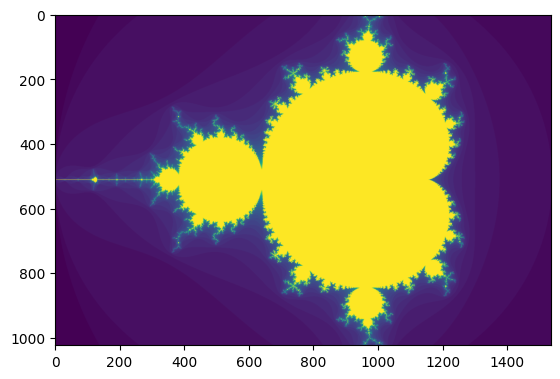

In [26]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt_py = timer() - start

print(f"Mandelbrot creado en el CPU en {dt_py} s.")
plt.imshow(gimage)

**Código con NUMBA**

In [27]:
mandel_numba = jit(nb.uint32(nb.float32, nb.float32, nb.uint32))(mandel)

In [28]:
@jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color

Mandelbrot creado on CPU con NUMBA en 0.2494461039999578 s.


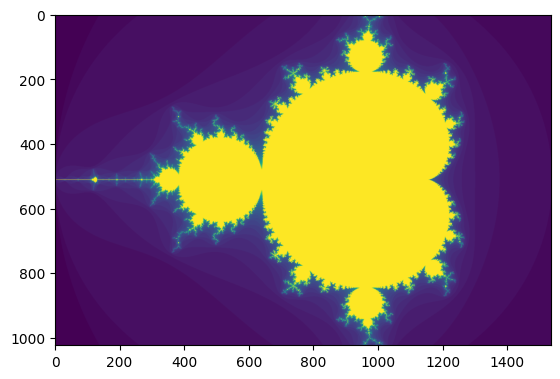

In [29]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt_numba = timer() - start

print(f"Mandelbrot creado on CPU con NUMBA en {dt_numba} s.")
plt.imshow(gimage);

**Código NUMBA con GPU**

In [30]:
mandel_gpu = cuda.jit('f8, f8, uint32', device=True)(mandel)

In [31]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

@cuda.jit('f8, f8, f8, f8, uint8[:,:], uint32')
def create_fractal_kernel(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape

    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x # stride in x
    gridY = cuda.gridDim.y * cuda.blockDim.y # stride in y

    for x in range(startX, width, gridX):
        real = xmin + x*pixel_size_x
        for y in range(startY, height, gridY):
            imag = ymin + y*pixel_size_y
            color = mandel_gpu(real, imag, iters)
            image[y, x]  = color

Mandelbrot creado en GPU en 0.0036261359999798515 s.


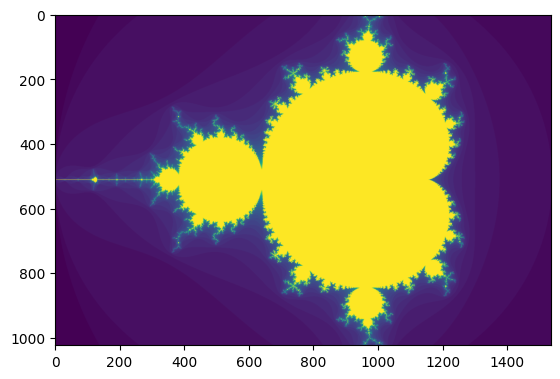

In [32]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
blockdim = (32, 8)
griddim = (32, 16)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = timer()
d_image = cuda.to_device(gimage)
create_fractal_kernel[griddim, blockdim](xmin, xmax, ymin, ymax, d_image, iters)
dt_cuda = timer() - start

print(f"Mandelbrot creado en GPU en {dt_cuda} s.")
plt.imshow(d_image);

In [33]:
print(f"Velocidad CPU:    {dt_py/dt_py}")
print(f"Aceleración Numba:  {dt_py/dt_numba}")
print(f"Aceleración CUDA:   {dt_py/dt_cuda}")

Velocidad CPU:    1.0
Aceleración Numba:  29.74185138606631
Aceleración CUDA:   2045.9764757971595


# Referencias

1.   https://numba.pydata.org/numba-doc/latest/user/5minguide.html
2.   http://numba.pydata.org/numba-doc/latest/user/threading-layer.html
3.   https://numba.pydata.org/numba-doc/dev/user/jit.html
4.   https://thedatafrog.com/en/articles/make-python-fast-numba/
5.   https://people.duke.edu/~ccc14/sta-663/CUDAPython.html
6. Tolga Soyata: GPU Parallel Program Development Using Cuda.
7. https://fisica.cab.cnea.gov.ar/gpgpu/images/clases/clase_1_cuda.pdf
8. Dongarra Foster: Source Book of parallel computing.




